# SVM Linear Classifiers with Text

In this notebook we will apply a Linear SVM to our text classification
problem.

As the bag of words representation of a document is high dimensional we will use $\chi^2$ feature selection to select a subspace of a manageable dimension. 


## Preliminaries

### Imports

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# for a progress bar on slow calculations
from ipywidgets import IntProgress
from IPython.display import display

import sys
sys.path.append("../..")
from E4525_ML import plots
import E4525_ML.text as text
from E4525_ML.multiclass_svm import SVMGDClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots

In [2]:
seed=23
np.random.seed(seed)

### Data

#### Data Directories

In [3]:
raw_data_dir=r"../../raw/C50/C50train"
test_dir    =r"../../raw/C50/C50test"
data_dir=r"../../data/C50"


#### Corpus

In [4]:
documents_filename=data_dir+"/C50_documents.csv"
documents=pd.read_csv(documents_filename,index_col="document_id")
documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50train/RobinSidel/147604newsML...,RobinSidel
1,../../raw/C50/C50train/RobinSidel/196812newsML...,RobinSidel
2,../../raw/C50/C50train/RobinSidel/219316newsML...,RobinSidel
3,../../raw/C50/C50train/RobinSidel/251225newsML...,RobinSidel
4,../../raw/C50/C50train/RobinSidel/177958newsML...,RobinSidel


In [5]:
test_documents_filename=data_dir+"/C50_test_documents.csv"
test_documents=pd.read_csv(test_documents_filename,index_col="document_id")
test_documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50test/RobinSidel/347781newsML.txt,RobinSidel
1,../../raw/C50/C50test/RobinSidel/306379newsML.txt,RobinSidel
2,../../raw/C50/C50test/RobinSidel/324849newsML.txt,RobinSidel
3,../../raw/C50/C50test/RobinSidel/284041newsML.txt,RobinSidel
4,../../raw/C50/C50test/RobinSidel/363477newsML.txt,RobinSidel


In [6]:
scramble=True

In [7]:
if scramble:
    all_docs=pd.concat([documents,test_documents])
    print("all_docs.shape",all_docs.shape)
    msk=np.random.rand(len(all_docs))<0.5
    documents=all_docs[msk]
    test_documents=all_docs[~msk]
    print(documents.shape,test_documents.shape)

all_docs.shape (5000, 2)
(2584, 2) (2416, 2)



## Validation Set Creation

In [8]:
docs_train,docs_val,Y_train,Y_val=train_test_split(documents["filename"],documents["label"],test_size=0.2)

We use `set` features as those perform better for all the other classifiers.

We normalize vectors so that $x^T x =1$ for each document by using the `TFidfVectorizer` class with normalization set.

In [9]:
countVectorizer=TfidfVectorizer(input="filename",
                                      
                                       norm="l2",
                                       tokenizer=text.stem_tokenizer,
                                       stop_words=text.stop_words())

## Select More important Features

In [10]:
F=1000

In [11]:
X=countVectorizer.fit_transform(docs_train)
Y=Y_train

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
V=X.shape[1]
V

27771

In [13]:
dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
labels=dummies.columns
Z=dummies

In [14]:
transformer=SelectKBest(chi2,F) # get the best F based on chi2 metric

In [15]:
Xt=transformer.fit_transform(X,Z) # Return X with only the selected features

In [16]:
feature_idx=transformer.get_support(True)

In [17]:
index_2_word=countVectorizer.get_feature_names()

In [18]:
for idx in feature_idx[-10:]:
    print(idx,index_2_word[idx])

27584 yen
27610 yokich
27625 yorkshir
27639 yuan
27644 yueng
27695 zeller
27696 zeman
27701 zeneca
27712 zhao
27743 zinc


## Generic Text Classifier with Feature Selection

Selection $F$ features base of a $\chi^2$ test makes sense for any classifier.

For convenience we create a new wrapper classifier that selects $F$ features and calls the underlying
classier with them.

In [19]:
class TextChi2Classifier:
    def __init__(self,F,model):
        self.model=model
        self.transformer=SelectKBest(chi2,F)
    def fit(self,X,Y,X_val,Y_val):
        dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
        Z=dummies
        Xt=self.transformer.fit_transform(X,Z)
        Xt_val=self.transformer.transform(X_val)
        self.model.fit(Xt,Y,Xt_val,Y_val)
        return self
    def predict(self,X):
        Xt=self.transformer.transform(X)
        return self.model.predict(Xt)

 ##  SVM Classifier vs Number of Features

In [20]:
X=countVectorizer.fit_transform(docs_train)
Y=Y_train
X.shape,Y.shape

((2067, 27771), (2067,))

In [21]:
X_val=countVectorizer.transform(docs_val)
X_val.shape,Y_val.shape

((517, 27771), (517,))

In [22]:
Fs=[100,200,300,500,1000,2000,3000,5000,10000,20000,V]

In [23]:
base_model=SVMGDClassifier(max_iter=100, learning_rate=0.005,tol=1e-8)

In [24]:
# Display a progress bar that counts how many training rounds we have done so far
progress2= IntProgress(min=0, max=len(Fs),description="Trials:",bar_style="info")
display(progress2)


logistic_train_error=[]
logistic_val_error=[]
progress2.value=0
for F in Fs:
    print("F",F)
    model=TextChi2Classifier(F,base_model)
    model.fit(X,Y,X_val,Y_val)
    Y_pred=model.predict(X)
    logistic_train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    logistic_val_error.append(1-np.mean(Y_pred==Y_val))
    progress2.value+=1
print("Done.")

IntProgress(value=0, bar_style='info', description='Trials:', max=11)

F 100
2019-11-12 18:54:28|	0: TRAIN loss 100778.7042,  acc 0.0218 || VAL loss 25251.6087, acc 0.0116
2019-11-12 18:54:28|	10: TRAIN loss 26836.7374,  acc 0.3648 || VAL loss 7263.8818, acc 0.3037
2019-11-12 18:54:28|	20: TRAIN loss 21491.4869,  acc 0.4480 || VAL loss 5705.1761, acc 0.4004
2019-11-12 18:54:28|	30: TRAIN loss 18829.7256,  acc 0.4702 || VAL loss 5177.9989, acc 0.4159
2019-11-12 18:54:29|	40: TRAIN loss 17543.7254,  acc 0.4698 || VAL loss 4947.0264, acc 0.4236
2019-11-12 18:54:29|	50: TRAIN loss 16627.0394,  acc 0.4790 || VAL loss 4998.3743, acc 0.4062
2019-11-12 18:54:29|	60: TRAIN loss 16063.4708,  acc 0.4785 || VAL loss 4683.8166, acc 0.4217
2019-11-12 18:54:29|	70: TRAIN loss 15447.8183,  acc 0.4910 || VAL loss 4612.0885, acc 0.4275
2019-11-12 18:54:29|	80: TRAIN loss 14982.5898,  acc 0.4867 || VAL loss 4414.7719, acc 0.4333
2019-11-12 18:54:29|	90: TRAIN loss 14428.9237,  acc 0.4828 || VAL loss 4421.1253, acc 0.4352
2019-11-12 18:54:29|	99: TRAIN loss 14137.4793,  acc 

Text(0, 0.5, 'Classification Error')

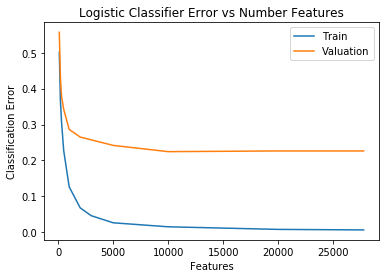

In [25]:
plt.plot(Fs,logistic_train_error,label="Train")
plt.plot(Fs,logistic_val_error,label="Valuation")
plt.legend()
plt.title("Logistic Classifier Error vs Number Features")
plt.xlabel("Features")
plt.ylabel("Classification Error")

In [26]:
best_idx=np.array(logistic_val_error).argmin()
best_F=Fs[best_idx]
print(best_F,logistic_val_error[best_idx])

10000 0.22437137330754353


1. The model is overfitting (training error is 0 after a few hundred Features)
2. Test Error stabilizes after roughtly 5k features
3. Logistic Regression performance does not degrade after we keep increasing the number of features

Best Accuracy is $\approx 83\%$, slightly worse than logistic regression.

## Regularization of the SVM Regression Classifier

In [27]:
penalties=[0.0001,0.001,0.01,0.1,1,10,100]

In [28]:
# Display a progress bar that counts how many training rounds we have done so far
#progress3= IntProgress(min=0, max=len(Cs),description="Trials:",bar_style="info")
#display(progress3)

train_error=[]
val_error=[]
#progress3.value=0
for penalty in penalties:
    print("penalty:",penalty)
    base_model=SVMGDClassifier(penalty=penalty,
                               max_iter=100, 
                               learning_rate=0.005,
                               tol=1e-8)
    model=TextChi2Classifier(best_F,base_model)
    model.fit(X,Y,X_val,Y_val)
    Y_pred=model.predict(X)
    train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    val_error.append(1-np.mean(Y_pred==Y_val))
    #progress3.value+=1
print("Done.")

penalty: 0.0001
2019-11-12 18:56:47|	0: TRAIN loss 101363.8229,  acc 0.0155 || VAL loss 25342.3300, acc 0.0251
2019-11-12 18:56:49|	10: TRAIN loss 1142.8217,  acc 0.9376 || VAL loss 2796.1648, acc 0.7524
2019-11-12 18:56:51|	20: TRAIN loss 745.9911,  acc 0.9507 || VAL loss 2694.6504, acc 0.7640
2019-11-12 18:56:54|	30: TRAIN loss 559.6827,  acc 0.9603 || VAL loss 2658.6479, acc 0.7621
2019-11-12 18:56:57|	40: TRAIN loss 448.5429,  acc 0.9671 || VAL loss 2652.1838, acc 0.7621
2019-11-12 18:57:00|	50: TRAIN loss 369.3355,  acc 0.9744 || VAL loss 2639.8474, acc 0.7640
2019-11-12 18:57:02|	60: TRAIN loss 309.7448,  acc 0.9797 || VAL loss 2633.8159, acc 0.7679
2019-11-12 18:57:04|	70: TRAIN loss 263.8630,  acc 0.9816 || VAL loss 2622.8839, acc 0.7718
2019-11-12 18:57:07|	80: TRAIN loss 228.4848,  acc 0.9831 || VAL loss 2611.4277, acc 0.7698
2019-11-12 18:57:09|	90: TRAIN loss 198.3121,  acc 0.9855 || VAL loss 2615.1128, acc 0.7737
2019-11-12 18:57:12|	99: TRAIN loss 174.7382,  acc 0.9860 ||

Text(0, 0.5, 'Classification Error')

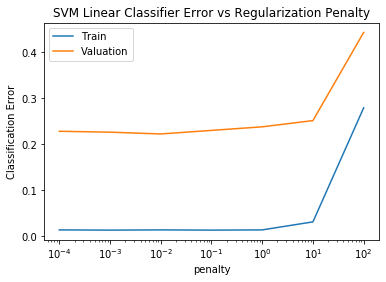

In [29]:
plt.plot(penalties,train_error,label="Train")
plt.plot(penalties,val_error,label="Valuation")
plt.legend()
plt.title("SVM Linear Classifier Error vs Regularization Penalty")
plt.xlabel(r"penalty")
plt.xscale("log")
plt.ylabel("Classification Error")

In [30]:
best_idx=np.array(val_error).argmin()
best_penalty=penalties[best_idx]
print(best_F,best_penalty,val_error[best_idx])

10000 0.01 0.22243713733075432


We have achieved a 84% accuracy comparable to Logistic Regression.

In [31]:
X=countVectorizer.fit_transform(documents["filename"])

In [32]:
X_test=countVectorizer.transform(test_documents["filename"])

In [33]:
Y=documents["label"]
Y_test=test_documents["label"]

In [34]:
base_model=SVMGDClassifier(penalty=best_penalty,
                               max_iter=100, 
                               learning_rate=0.005,
                               tol=1e-8)
model=TextChi2Classifier(best_F,base_model)
model.fit(X,Y,X_test,Y_test)

2019-11-12 19:00:52|	0: TRAIN loss 126548.1918,  acc 0.0298 || VAL loss 118351.4050, acc 0.0273
2019-11-12 19:00:55|	10: TRAIN loss 1515.1983,  acc 0.9241 || VAL loss 11443.1558, acc 0.7546
2019-11-12 19:00:59|	20: TRAIN loss 1006.2164,  acc 0.9412 || VAL loss 10787.5195, acc 0.7699
2019-11-12 19:01:02|	30: TRAIN loss 761.8960,  acc 0.9520 || VAL loss 10511.2428, acc 0.7761
2019-11-12 19:01:05|	40: TRAIN loss 618.6247,  acc 0.9640 || VAL loss 10436.4571, acc 0.7777
2019-11-12 19:01:08|	50: TRAIN loss 507.7678,  acc 0.9687 || VAL loss 10313.7117, acc 0.7781
2019-11-12 19:01:10|	60: TRAIN loss 429.9288,  acc 0.9764 || VAL loss 10259.4596, acc 0.7798
2019-11-12 19:01:13|	70: TRAIN loss 370.9586,  acc 0.9795 || VAL loss 10263.9720, acc 0.7844
2019-11-12 19:01:16|	80: TRAIN loss 323.5381,  acc 0.9826 || VAL loss 10164.9556, acc 0.7868
2019-11-12 19:01:19|	90: TRAIN loss 286.2521,  acc 0.9834 || VAL loss 10223.9323, acc 0.7868
2019-11-12 19:01:22|	99: TRAIN loss 252.8285,  acc 0.9876 || VAL 

In [35]:
Y_pred=model.predict(X_test)
np.mean(Y_pred==Y_test)

0.7893211920529801

We achieve nearly 86% accuracy, very slighly better than LogisticRegression (85.80% vs 85.76%)